In [1]:
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt
import pandas as pd
import dask
import cartopy.crs as ccrs
import cartopy.feature as cfeature 

from eofs.xarray import Eof

In [2]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster(n_workers=4, processes=False, threads_per_worker=1)
client = Client(cluster)

In [3]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://128.174.76.3:8787/status,
Dashboard: http://128.174.76.3:8787/status,Workers: 4
Total threads: 4,Total memory: 503.48 GiB
Status: running,Using processes: False
Comm: inproc://128.174.76.3/68739/1,Workers: 4
Dashboard: http://128.174.76.3:8787/status,Total threads: 4
Started: Just now,Total memory: 503.48 GiB
Comm: inproc://128.174.76.3/68739/6,Total threads: 1
Dashboard: http://128.174.76.3:33425/status,Memory: 125.87 GiB
Nanny: None,


# Process the data and mask it over land

In [4]:
#Download the land/sea mask 
land_sea_mask = xr.open_dataset(r'https://rda.ucar.edu/thredds/dodsC/files/g/ds633.0/e5.oper.invariant/197901/e5.oper.invariant.128_172_lsm.ll025sc.1979010100_1979010100.nc',\
    engine='netcdf4').sel(latitude=slice(65.,-65., 4),longitude=slice(120., 300.,4))

land_sea_mask

OSError: [Errno -90] NetCDF: file not found: b'https://rda.ucar.edu/thredds/dodsC/files/g/ds633.0/e5.oper.invariant/197901/e5.oper.invariant.128_172_lsm.ll025sc.1979010100_1979010100.nc'

In [5]:
pr = pd.date_range(start='1979-01-01', end='2021-12-01',freq='YS')
def get_era5_rda(url_start, middle_url, end_url, time_frame):
     """
     This file returns a list of file names from 
     the ERA-5 archive on the RDA server.
     """
     file_list=[]
     for date in time_frame:
     # get recent year and month
          year = date.strftime('%Y')
          month = date.strftime('%Y%m%d%H')
          month2 = (date + pd.DateOffset(months=11)).strftime('%Y%m%d%H')
    # build complete file name
          single_file=(url_start+year+middle_url+month+'_'+month2+end_url)
          file_list.append(single_file)
     return file_list

In [6]:
#Get the monthly data from the ERA-5 RDA server
sst_url_start= 'https://rda.ucar.edu/thredds/dodsC/files/g/ds633.1_nc/e5.moda.an.sfc/'
sst_middle_url = '/e5.moda.an.sfc.128_034_sstk.ll025sc.'
url_end = '.nc'
precip_url_start = 'https://rda.ucar.edu/thredds/dodsC/files/g/ds633.1_nc/e5.moda.fc.sfc.accumu/'
precip_middle_url = '/e5.moda.fc.sfc.accumu.128_228_tp.ll025sc.'
sst_list = get_era5_rda(sst_url_start, sst_middle_url, url_end, pr)
precip_list = get_era5_rda(precip_url_start, precip_middle_url, url_end, pr)
sst_data = xr.open_mfdataset(sst_list, parallel=True, chunks={'time':'50MB'})\
    .sel(latitude=slice(65,-65, 4),longitude=slice(120, 300,4))
precip_data = xr.open_mfdataset(precip_list, parallel=True, chunks={'time':'50MB'})\
    .sel(latitude=slice(65,-65, 4),longitude=slice(120, 300,4))
#https://rda.ucar.edu/thredds/dodsC/files/g/ds633.1_nc/e5.moda.an.sfc/1979/e5.moda.an.sfc.128_034_sstk.ll025sc.1979010100_1979120100.nc

#https://rda.ucar.edu/thredds/dodsC/files/g/ds633.1_nc/e5.moda.fc.sfc.accumu/1979/e5.moda.fc.sfc.accumu.128_143_cp.ll025sc.1979010100_1979120100.nc

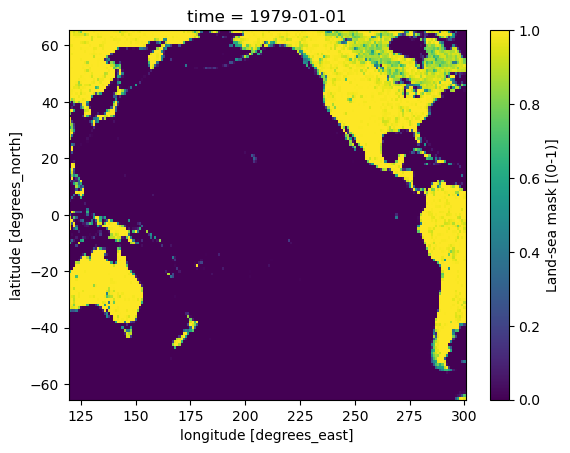

In [11]:
ls_mask = land_sea_mask['LSM'][0,:,:]

ls_mask.plot.pcolormesh()

In [8]:
sst_means = sst_data['SSTK'].groupby(sst_data.time.dt.month).mean(dim='time').compute()
precip_means = precip_data['TP'].groupby(precip_data.time.dt.month).mean(dim='time').compute()




2022-10-14 20:53:19,740 - distributed.nanny - WARNING - Restarting worker


In [9]:
grouped_ssts = sst_data['SSTK'].groupby(sst_data.time.dt.month)
grouped_precip = precip_data['TP'].groupby(precip_data.time.dt.month)

sst_anomaly = grouped_ssts - sst_means.compute()
precip_anomaly = grouped_precip - precip_means.compute()

In [10]:
#Save the data
sst_anomaly.to_netcdf('./sst_data_anoms.nc')
precip_anomaly.to_netcdf('./precip_data_anoms.nc')

2022-10-14 20:53:28,809 - distributed.nanny - WARNING - Restarting worker
2022-10-14 20:53:33,031 - distributed.nanny - WARNING - Restarting worker


# Deseaonalize, detrend and standardize the data

In [4]:
#Load the saved data from the first step

sst_masked_data = xr.open_dataset('./sst_data_anoms.nc')
precip_masked_data = xr.open_dataset('./precip_data_anoms.nc')


In [5]:
#Standaridize the data
sst_climo_mean = sst_masked_data.groupby("time.month").mean(dim='time')
precip_climo_mean = precip_masked_data.groupby("time.month").mean(dim='time')
sst_std= sst_masked_data.groupby("time.month").std('time')
precip_std = precip_masked_data.groupby("time.month").std('time')

sst_stand_anoms = xr.apply_ufunc(
                                lambda x,m,s: (x-m)/s,
                                sst_masked_data.groupby("time.month"), sst_climo_mean,
                                sst_std
                                )
precip_stand_anoms = xr.apply_ufunc(
                                lambda x,m,s: (x-m)/s,
                                precip_masked_data.groupby("time.month"), precip_climo_mean,
                                precip_std
                                )    

/data/keeling/a/melinda3/miniconda3/envs/py3-eofs/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/data/keeling/a/melinda3/miniconda3/envs/py3-eofs/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/data/keeling/a/melinda3/miniconda3/envs/py3-eofs/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/data/keeling/a/melinda3/miniconda3/envs/py3-eofs/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/data/keeling/a/melinda3/miniconda3/envs/py3-eofs/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878

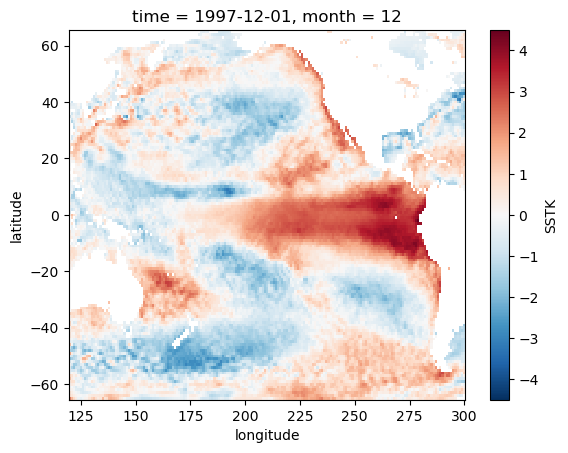

In [6]:
sst_stand_anoms['SSTK'].sel(time='1997-12-01').plot.pcolormesh()

In [7]:
#Detrend the data
def detrending(da, dim, deg=1):
    p = da.polyfit(dim=dim, deg=deg)
    fit=xr.polyval(da[dim], p.polyfit_coefficients)

    return da-fit

sst_detrend = detrending(sst_stand_anoms['SSTK'], 'time')
precip_detrend = detrending(precip_stand_anoms['TP'], 'time')





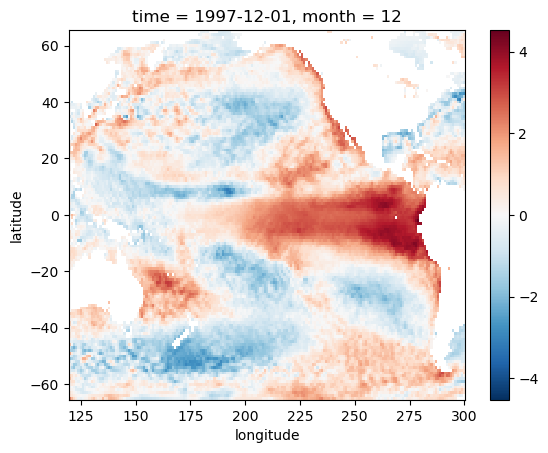

In [8]:
sst_detrend.sel(time='1997-12-01').plot()

# EOF Analysis on SST data

In [9]:
coslat = np.cos(np.deg2rad(sst_detrend.coords['latitude'].values))
wgts = np.sqrt(coslat)[..., np.newaxis]
solver = Eof(sst_detrend, weights=wgts)


In [10]:
#Plot the first 5 EOFs
eof1 = solver.eofsAsCorrelation(neofs=5)


/data/keeling/a/melinda3/miniconda3/envs/py3-eofs/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


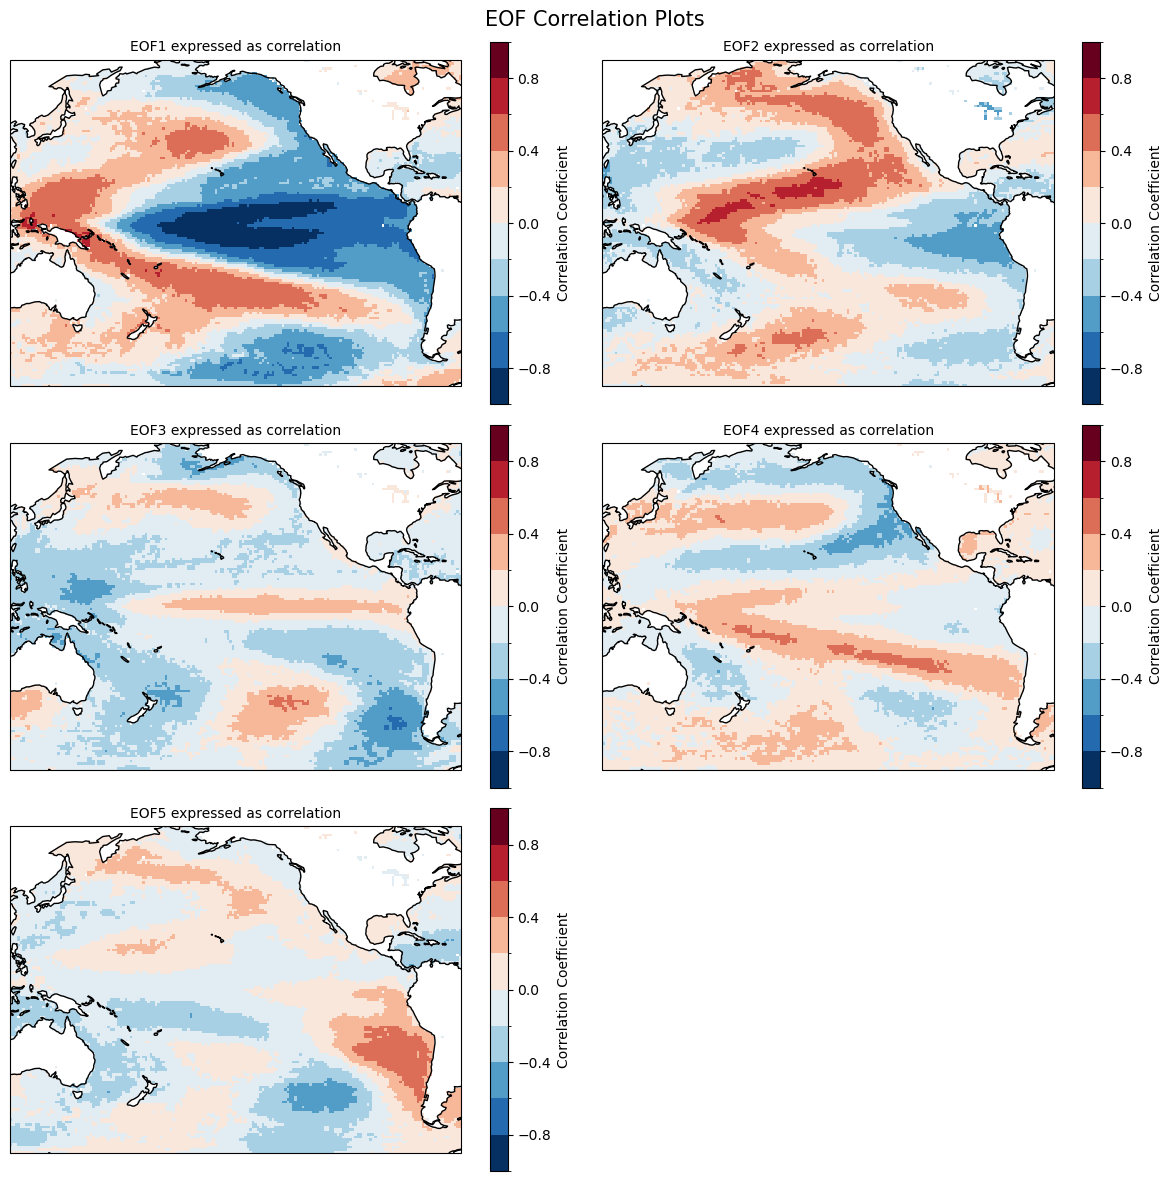

In [11]:
f = plt.figure(figsize= (12, 12))
plt.suptitle('EOF Correlation Plots', fontsize = 15)
clevs = np.linspace(-1, 1, 11)
ax1 = plt.subplot(3,2,1,projection=ccrs.PlateCarree(central_longitude=210))
eof1[0].plot.pcolormesh(ax=ax1, levels=clevs, cmap=plt.cm.RdBu_r,
                             transform=ccrs.PlateCarree(),
                             cbar_kwargs={'label':'Correlation Coefficient'})
ax1.add_feature(cfeature.COASTLINE, color='k', edgecolor='k')
ax1.set_title('EOF1 expressed as correlation', fontsize=10)

ax2 = plt.subplot(3,2,2,projection=ccrs.PlateCarree(central_longitude=210))
eof1[1].plot.pcolormesh(ax=ax2, levels=clevs, cmap=plt.cm.RdBu_r,
                             transform=ccrs.PlateCarree(),
                             cbar_kwargs={'label':'Correlation Coefficient'})
ax2.add_feature(cfeature.COASTLINE, color='k', edgecolor='k')
ax2.set_title('EOF2 expressed as correlation', fontsize=10)

ax3 = plt.subplot(3,2,3,projection=ccrs.PlateCarree(central_longitude=210))
eof1[2].plot.pcolormesh(ax=ax3, levels=clevs, cmap=plt.cm.RdBu_r,
                             transform=ccrs.PlateCarree(),
                             cbar_kwargs={'label':'Correlation Coefficient'})
ax3.add_feature(cfeature.COASTLINE, color='k', edgecolor='k')
ax3.set_title('EOF3 expressed as correlation', fontsize=10)

ax4 = plt.subplot(3,2,4,projection=ccrs.PlateCarree(central_longitude=210))
eof1[3].plot.pcolormesh(ax=ax4, levels=clevs, cmap=plt.cm.RdBu_r,
                             transform=ccrs.PlateCarree(),
                             cbar_kwargs={'label':'Correlation Coefficient'})
ax4.add_feature(cfeature.COASTLINE, color='k', edgecolor='k')
ax4.set_title('EOF4 expressed as correlation', fontsize=10)

ax5 = plt.subplot(3,2,5,projection=ccrs.PlateCarree(central_longitude=210))
eof1[4].plot.pcolormesh(ax=ax5, levels=clevs, cmap=plt.cm.RdBu_r,
                             transform=ccrs.PlateCarree(),
                             cbar_kwargs={'label':'Correlation Coefficient'})
ax5.add_feature(cfeature.COASTLINE, color='k', edgecolor='k')
ax5.set_title('EOF5 expressed as correlation', fontsize=10)

plt.tight_layout()

# Plot the percent of variance explained by the first 10 EOFs

In [12]:
varfrac = solver.varianceFraction()

(2.1278774205971215e-33, 23.654850920331114)

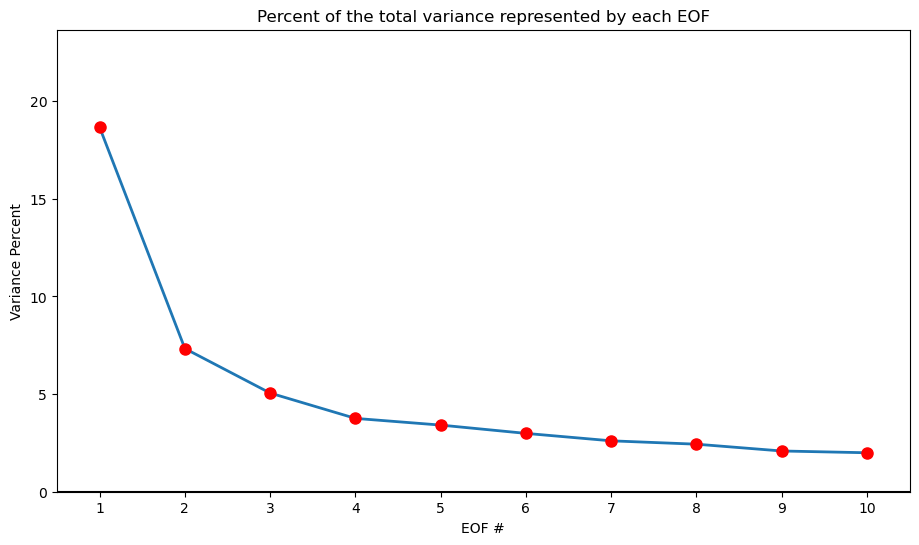

In [13]:
plt.figure(figsize=(11,6))
eof_num = range(1, 11)
plt.plot(eof_num, varfrac[0:10]*100, linewidth=2)
plt.plot(eof_num, varfrac[0:10]*100, linestyle='None', marker="o", color='r', markersize=8)
plt.axhline(0, color='k')
plt.xticks(range(1, 16))
plt.title('Percent of the total variance represented by each EOF')
plt.xlabel('EOF #')
plt.ylabel('Variance Percent')
plt.xlim(0.5,10.5)
plt.ylim(np.min(varfrac), np.max(varfrac*100)+5)

# Reconstruct the SST field from the 5 EOFs and plot the corr coef map

In [14]:
solver._

AttributeError: 'Eof' object has no attribute '_'

In [15]:
reconstruction = solver.reconstructedField(1)
reconstruction

TypeError: Using a DataArray object to construct a variable is ambiguous, please extract the data using the .data property.

NameError: name 'reconstruction' is not defined

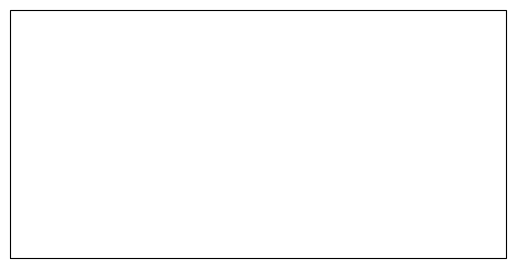

In [ ]:
clevs = np.linspace(-3, 3, 21)
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=190))
fill = reconstruction.sel(time='1998-01-15', method='nearest').plot.contourf(ax=ax, levels=clevs, cmap=plt.cm.RdBu_r,
                             add_colorbar=False, transform=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE, color='k', edgecolor='k')
cb = plt.colorbar(fill, orientation='horizontal')
cb.set_label('SST Anomalies (reconstructed)', fontsize=12)

# Compute the Corr Coeff between SST EOF1 and monthly mean standardized precipitation anomalies

In [32]:
precip_sst_corr = xr.corr(sst_detrend, precip_detrend, dim='time')

/data/keeling/a/melinda3/miniconda3/envs/atms523_env/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/data/keeling/a/melinda3/miniconda3/envs/atms523_env/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


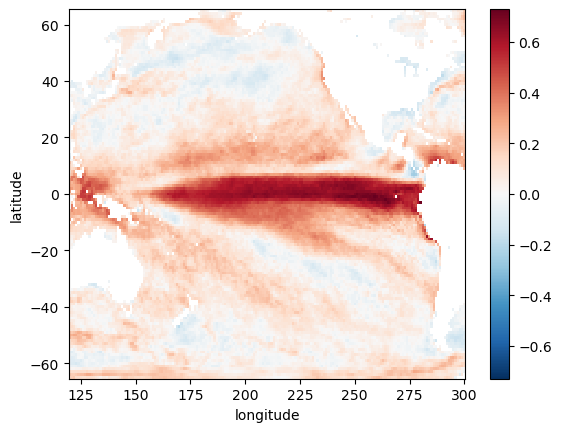

In [33]:
precip_sst_corr.plot.pcolormesh()

In [17]:
client.close()

2022-10-13 22:15:41,677 - distributed.nanny - WARNING - Worker process still alive after 3.9999965667724613 seconds, killing
2022-10-13 22:15:41,678 - distributed.nanny - WARNING - Worker process still alive after 3.9999988555908206 seconds, killing
2022-10-13 22:15:41,726 - tornado.application - ERROR - Exception in callback functools.partial(<bound method AsyncProcess._on_exit of <AsyncProcess Dask Worker process (from Nanny)>>, -15)
Traceback (most recent call last):
  File "/data/keeling/a/melinda3/miniconda3/envs/atms523_env/lib/python3.10/site-packages/tornado/ioloop.py", line 740, in _run_callback
    ret = callback()
  File "/data/keeling/a/melinda3/miniconda3/envs/atms523_env/lib/python3.10/site-packages/distributed/process.py", line 139, in _on_exit
    self._exit_callback(self)
  File "/data/keeling/a/melinda3/miniconda3/envs/atms523_env/lib/python3.10/site-packages/distributed/nanny.py", line 695, in _on_exit
    self.mark_stopped()
  File "/data/keeling/a/melinda3/minicond